In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

from model import GrammarVAE
from util import Timer, AnnealKL, load_data

In [2]:
# Init model, dont train it and generate some equations
ENCODER_HIDDEN = 20
Z_SIZE = 2
DECODER_HIDDEN = 20
RNN_TYPE = 'lstm'
BATCH_SIZE = 32
MAX_LENGTH = 15
OUTPUT_SIZE = 12
LR = 1e-2
CLIP = 5.
PRINT_EVERY = 100
EPOCHS = 3

model = GrammarVAE(ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE, RNN_TYPE)

In [9]:
batch_size = 2
x = torch.randn(batch_size, OUTPUT_SIZE, MAX_LENGTH)  # OUTPUT_SIZE: number of rules (for 1-hot encoding)
mu, sigma = model.encoder(x)
print(mu, sigma)  # z

logits = model.decoder(mu, 15)
print(logits.shape)

tensor([[ 0.1680, -0.2196],
        [ 0.1450, -0.2121]], grad_fn=<AddmmBackward0>) tensor([[0.7805, 0.7860],
        [0.8027, 0.7900]], grad_fn=<SoftplusBackward0>)
torch.Size([2, 15, 12])


In [126]:
# torch.manual_seed(0)

import model as m
from importlib import reload
import util
reload(m)

# Init model, dont train it and generate some equations
ENCODER_HIDDEN = 20
Z_SIZE = 2
DECODER_HIDDEN = 20
RNN_TYPE = 'lstm'
BATCH_SIZE = 32
MAX_LENGTH = 15
OUTPUT_SIZE = 12
LR = 1e-2
CLIP = 5.
PRINT_EVERY = 100
EPOCHS = 3

model = m.GrammarVAE(ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE, RNN_TYPE)  # .to(device='mps')

batch_size = 1
x = torch.randn(batch_size, OUTPUT_SIZE, MAX_LENGTH).to(model.device) * 10  # OUTPUT_SIZE: number of rules (for 1-hot encoding)
mu, sigma = model.encoder(x)
print(f'{mu = }')

rules = model.generate(mu, sample=False, max_length=15)
print(rules)

if len(rules) < 15:
    tree = util.make_nltk_tree(rules)
    print(tree)
else:
    print('Invalid. Too many rules.')

mu = tensor([[-0.1692,  0.0015]], grad_fn=<AddmmBackward0>)
[S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T]
Invalid. Too many rules.


In [89]:
tree.pprint()

(S (T 3))


In [124]:
next(model.parameters()).is_mps

True

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

In [106]:
import re
import nltk
import grammar

MAX_LEN = 15

eqs = ['sin(x*2)',
      'exp(x)+x',
      'x/3',
      '3*exp(2/x)']

datapath = r'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/grammarVAE-keras/data/equation2_15_dataset.txt'
with open(datapath, 'r') as f:
    eqs = f.readlines()
    eqs = [eq.strip('\n') for eq in eqs]
eqs = eqs[:1000]

def tokenize(s):
    funcs = ['sin', 'exp']
    for fn in funcs: s = s.replace(fn+'(', fn+' ')
    s = re.sub(r'([^a-z ])', r' \1 ', s)
    for fn in funcs: s = s.replace(fn, fn+'(')
    return s.split()

_productions = grammar.GCFG.productions()
_tokenize = tokenize
_parser = nltk.ChartParser(grammar.GCFG)
_n_chars = len(_productions)

_prod_map = {}
for ix, prod in enumerate(_productions):
    _prod_map[prod] = ix


def onehot_encode(eqs):
    assert type(eqs) == list
    tokens = map(_tokenize, eqs)
    parse_trees = [next(_parser.parse(t)) for t in tokens]
    productions_seq = [tree.productions() for tree in parse_trees]

    indices = [np.array([_prod_map[prod] for prod in entry], dtype=int) for entry in productions_seq]

    one_hot = np.zeros((len(indices), MAX_LEN, _n_chars), dtype=np.float32)
    for i in range(len(indices)):
        num_productions = len(indices[i])
        one_hot[i][np.arange(num_productions),indices[i]] = 1.
        one_hot[i][np.arange(num_productions, MAX_LEN),-1] = 1.
    return one_hot

one_hot = onehot_encode(eqs)

In [128]:
import h5py

output_path = r'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/grammar-vae/data/equation2_15_dataset_parsed.h5'

with h5py.File(output_path, 'w') as f:
    f.create_dataset('data', data=one_hot)


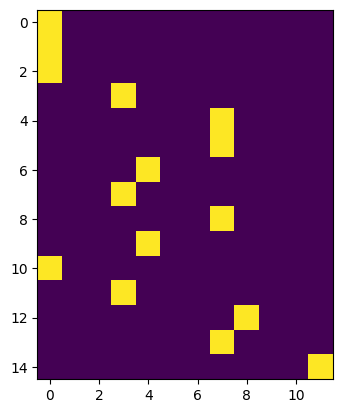

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [111]:
from matplotlib import pyplot as plt

plt.imshow(one_hot[4, ...])
plt.show()

one_hot